Step 1: Train/Test Split

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split

data = np.load("data/5_less_tensor.npz")
X = data["inputs"]
Y = data["outputs"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

Step 2: CNN Architecture (Pytorch)

In [13]:
import torch
import torch.nn as nn

class ChessMoveCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(12, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 2, kernel_size=1)  # 2 channels: start and end square
        )

    def forward(self, x):
        return self.net(x)

Step 3: Loss Function and Training Setup

In [14]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
test_ds  = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ChessMoveCNN().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

cuda


Step 4: Training Loop

In [15]:
train_losses = []
test_losses = []
epochs = 10

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation
    model.eval()
    total_test_loss = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Test Loss: {avg_test_loss:.4f}")

Epoch 1/10 - Train Loss: 0.6021 - Test Loss: 0.3936
Epoch 2/10 - Train Loss: 0.2138 - Test Loss: 0.1054
Epoch 3/10 - Train Loss: 0.0750 - Test Loss: 0.0584
Epoch 4/10 - Train Loss: 0.0506 - Test Loss: 0.0476
Epoch 5/10 - Train Loss: 0.0428 - Test Loss: 0.0433
Epoch 6/10 - Train Loss: 0.0391 - Test Loss: 0.0414
Epoch 7/10 - Train Loss: 0.0369 - Test Loss: 0.0399
Epoch 8/10 - Train Loss: 0.0354 - Test Loss: 0.0394
Epoch 9/10 - Train Loss: 0.0347 - Test Loss: 0.0390
Epoch 10/10 - Train Loss: 0.0337 - Test Loss: 0.0388


Step 5: Loss Plotting and Test Case Visualization

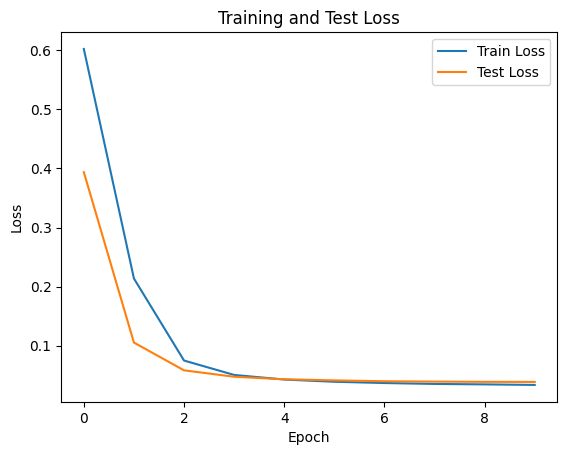

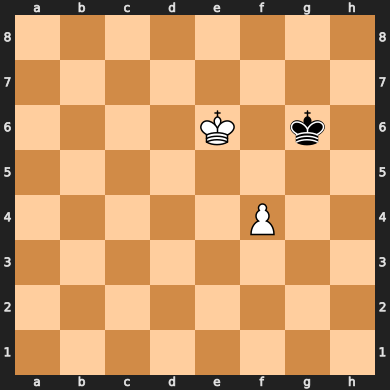

Top 5 predicted moves (start, end, uci, score):
g6g7: 0.2340
g6h7: 0.0360
g6h5: 0.0325
g6h6: 0.0235
g6e8: 0.0041

Ground Truth Move: g6g7


In [23]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Test Loss")
plt.show()

import utils
import chess

def get_top_5_moves(pred_tensor):
    pred = torch.sigmoid(pred_tensor).detach().cpu().numpy()  # shape (2, 8, 8)
    start_flat = pred[0].flatten()
    end_flat = pred[1].flatten()
    
    moves = []
    for start in range(64):
        for end in range(64):
            score = start_flat[start] * end_flat[end]
            moves.append((score, start, end))

    top5 = sorted(moves, key=lambda x: -x[0])[:5]
    return [(chess.square_name(s), chess.square_name(e), f"{chess.square_name(s)}{chess.square_name(e)}", float(score)) for score, s, e in top5]

# Pick a test sample
idx = np.random.randint(len(X_test))
x = torch.tensor(X_test[idx:idx+1], dtype=torch.float32).to(device)
y_pred = model(x)[0]  # shape: (2, 8, 8)

board = utils.tensor_to_board(X_test[idx])
display(board)
top5_moves = get_top_5_moves(y_pred)

print("Top 5 predicted moves (start, end, uci, score):")
for start, end, uci, score in top5_moves:
    print(f"{uci}: {score:.4f}")

y_true = Y_test[idx]  # shape: (2, 8, 8)
# Find the '1' (or highest value) in the start plane and end plane
start_idx = np.argmax(y_true[0].flatten()) 
end_idx   = np.argmax(y_true[1].flatten()) 

# Convert to square names just like the predicted moves
start_sq = chess.square_name(start_idx)
end_sq   = chess.square_name(end_idx)
true_uci = f"{start_sq}{end_sq}"

print("\nGround Truth Move:", true_uci)